# CS5228 Project - Group 15

In [3]:
# Ensures that the notebook will reload external python modules;
# i.e. when you change something in your .py script, you do not need to re-import the .py script file.
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Making all the required imports:

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from src.utils import clean_data


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rahulbhargava/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# setting option to display full sentence in the head
pd.set_option('display.max_colwidth', None)

----------

#### EDA and Data Preprocessing

In [6]:
# Reading dataset
fakenews_df = pd.read_csv('data/WELFake_Dataset.csv')
# fakenews_df.head()
# fakenews_df.shape

In [7]:
# check the nulls
fakenews_df.isna().sum()

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

In [8]:
# dropping null values
fakenews_df.dropna(inplace=True)
# Reset the index
fakenews_df = fakenews_df.reset_index(drop=True)
# Drop the column
fakenews_df = fakenews_df.drop('Unnamed: 0', axis=1)
# fakenews_df.head()


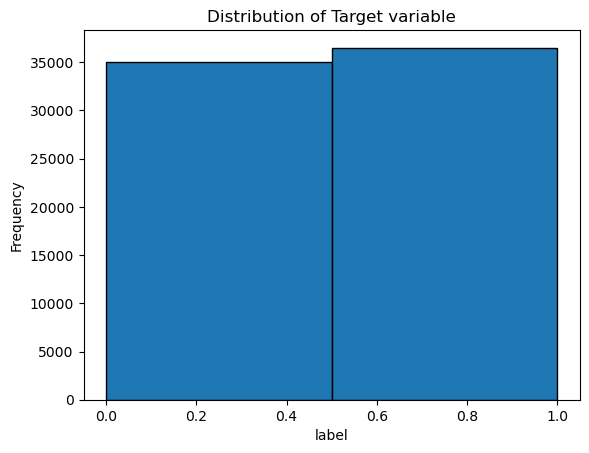

In [9]:
# distribution of label
# Plot a histogram
plt.hist(fakenews_df['label'], bins=2, edgecolor='black')

# Set the title and labels
plt.title('Distribution of Target variable')
plt.xlabel('label')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [10]:
# combine title and text columns into single column
fakenews_df['title_text'] = fakenews_df['title'] + ' ' + fakenews_df['text']

# dropping individual columns
fakenews_df = fakenews_df.drop(['title','text'], axis=1)

# moving column to begining of the dataframe
column_to_move = fakenews_df.pop('title_text')
fakenews_df.insert(0, 'title_text', column_to_move)

In [11]:
# convert title and text columns to lower case
fakenews_df['title_text'] = fakenews_df['title_text'].str.lower()

# remove spaces front, back and middle of text
fakenews_df['title_text'] = fakenews_df['title_text'].str.strip().replace(' ','')

# remove punchuation
# fakenews_df['title_text'] = fakenews_df['title_text'].str.replace(r'[^\w\s]', '')
fakenews_df = clean_data(fakenews_df, 'title_text')
fakenews_df.head(1)


title_text  \
0  law enforcement on high alert following threats against cops and whites on 911by blacklivesmatter and fyf911 terrorists video no comment is expected from barack obama members of the fyf911 or fukyoflag and blacklivesmatter movements called for the lynching and hanging of white people and cops they encouraged others on a radio show tuesday night to  turn the tide  and kill white people and cops to send a message about the killing of black people in americaone of the fyoflag organizers is called  sunshine  she has a radio blog show hosted from texas called  sunshine s fing opinion radio show a snapshot of her fyf911 lolatwhitefear twitter page at 953 pm shows that she was urging supporters to  call now fyf911 tonight we continue to dismantle the illusion of white below is a snapshot twitter radio call invite   fyf911the radio show aired at 1000 pm eastern standard timeduring the show callers clearly call for  lynching  and  killing  of white peoplea 239 minute clip from the radio show can be heard here it was provided to breitbart texas by someone who would like to be referred to as  hannibal  he has already received death threats as a result of interrupting fyf911 conference callsan unidentified black man said  when those mother fkers are by themselves that s when when we should start fing them up like they do us when a bunch of them niers takin  one of us out that s how we should roll up  he said  cause we already roll up in gangs anyway there should be six or seven black mother fckers see that white person and then lynch their ass let s turn the tables they conspired that if  cops started losing people  then  there will be a state of emergency he speculated that one of two things would happen  a bigass r s war  or  niers they are going to start backin  up we are already getting killed out here so what the fk we got to lose sunshine could be heard saying  yep that s true that s so fking true he said  we need to turn the tables on them our kids are getting shot out here somebody needs to become a sacrifice on their sidehe said  everybody ain t down for that st or whatever but like i say everybody has a different position of war  he continued  because they don t give a fk anyway  he said again  we might as well utilized them for that st and turn the tables on these ners he said that way  we can start lookin  like we ain t havin  that many casualties and there can be more causalities on their side instead of ours they are out their killing black people black lives don t matter that s what those mother fkers   so we got to make it matter to them find a mother fker that is alone snap his ass and then fin hang him from a damn tree take a picture of it and then send it to the mother fkers we  just need one example  and  then people will start watchin   this will turn the tables on st he said he said this will start  a trickledown effect  he said that when one white person is hung and then they are just  flathanging  that will start the  trickledown effect  he continued  black people are good at starting trends he said that was how  to get the upperhand another black man spoke up saying they needed to kill  cops that are killing us the first black male said  that will be the best method right there breitbart texas previously reported how sunshine was upset when  racist white people  infiltrated and disrupted one of her conference calls she subsequently released the phone number of one of the infiltrators the veteran immediately started receiving threatening callsone of the fyoflag movement supporters allegedly told a veteran who infiltrated their publicly posted conference call  we are going to rape and gut your pregnant wife and your fing piece of sht unborn creature will be hung from a tree breitbart texas previously encountered sunshine at a sandra bland protest at the waller county jail in texas where she said all white people should be killed she told journalists and photographers  you see this nappyass hair on m

#### NLP Steps (Stopword Removal and Stemming)

In [12]:
# split and Remove stopwords from title_text column
stop = stopwords.words('english')
fakenews_df['title_text'] = fakenews_df['title_text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop))

# Apply stemming
stemmer = PorterStemmer()
fakenews_df['title_text'] = fakenews_df['title_text'].apply(lambda x: ' '.join(stemmer.stem(word) for word in x.split()))

fakenews_df.head(1)

,title_text,label
0,law enforc high alert follow threat cop white 911bi blacklivesmatt fyf911 terrorist video comment expect barack obama member fyf911 fukyoflag blacklivesmatt movement call lynch hang white peopl cop encourag other radio show tuesday night turn tide kill white peopl cop send messag kill black peopl americaon fyoflag organ call sunshin radio blog show host texa call sunshin fing opinion radio show snapshot fyf911 lolatwhitefear twitter page 953 pm show urg support call fyf911 tonight continu dismantl illus white snapshot twitter radio call invit fyf911th radio show air 1000 pm eastern standard timedur show caller clearli call lynch kill white peoplea 239 minut clip radio show heard provid breitbart texa someon would like refer hannib alreadi receiv death threat result interrupt fyf911 confer callsan unidentifi black man said mother fker start fing like us bunch nier takin one us roll said caus alreadi roll gang anyway six seven black mother fcker see white person lynch ass let turn tabl conspir cop start lose peopl state emerg specul one two thing would happen bigass r war nier go start backin alreadi get kill fk got lose sunshin could heard say yep true fking true said need turn tabl kid get shot somebodi need becom sacrific sideh said everybodi st whatev like say everybodi differ posit war continu give fk anyway said might well util st turn tabl ner said way start lookin like havin mani casualti causal side instead kill black peopl black live matter mother fker got make matter find mother fker alon snap ass fin hang damn tree take pictur send mother fker need one exampl peopl start watchin turn tabl st said said start trickledown effect said one white person hung flathang start trickledown effect continu black peopl good start trend said get upperhand anoth black man spoke say need kill cop kill us first black male said best method right breitbart texa previous report sunshin upset racist white peopl infiltr disrupt one confer call subsequ releas phone number one infiltr veteran immedi start receiv threaten callson fyoflag movement support allegedli told veteran infiltr publicli post confer call go rape gut pregnant wife fing piec sht unborn creatur hung tree breitbart texa previous encount sunshin sandra bland protest waller counti jail texa said white peopl kill told journalist photograph see nappyass hair head mean one milit negro said protest redneck motherfk murder sandra bland nappi hair like fyf911 black radic say hold imperi power actual respons terrorist attack septemb 11th account day report breitbart texa sever websit twitter handl movement palmetto star describ one head organ said youtub video support burn symbol illus superior fals white supremaci like american flag british flag polic uniform ku klux klan hoodssierra mcgrone nocturnu libertu post help young afrikan clean rag oppress post two photo one appear photo black man wipe nake butt american flagfor entir stori breitbart news,1


### Exploratory Data Analysis

**SKIP WORDCLOUD CREATION IN THE FUTURE**

In [13]:
from wordcloud import WordCloud

all_text = ' '.join(fakenews_df['title_text'])
fake_text = ' '.join(fakenews_df[fakenews_df['label'] == 1]['title_text'])
real_text = ' '.join(fakenews_df[fakenews_df['label'] == 0]['title_text'])

all_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
fake_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(fake_text)
real_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(real_text)

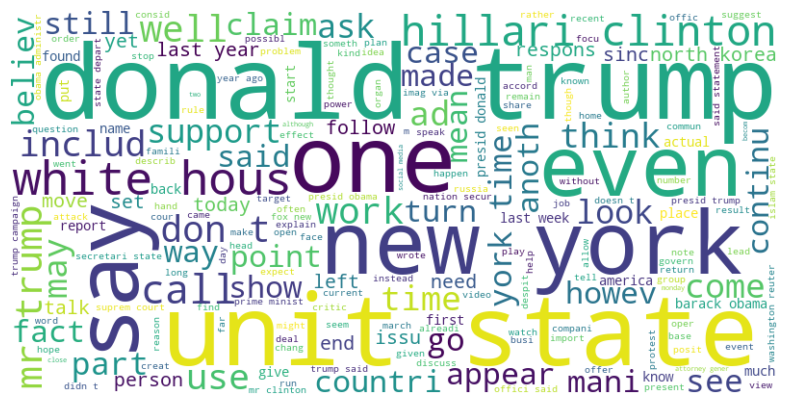

In [14]:
plt.figure(figsize=(10, 5))
plt.imshow(all_wordcloud, interpolation='bilinear')
plt.axis("off")  # Don't show the axes to keep it clean
plt.show()

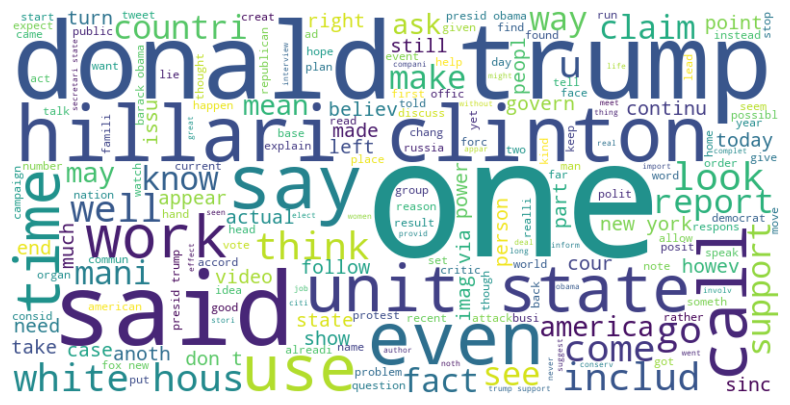

In [15]:
plt.figure(figsize=(10, 5))
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.axis("off")  # Don't show the axes to keep it clean
plt.show()

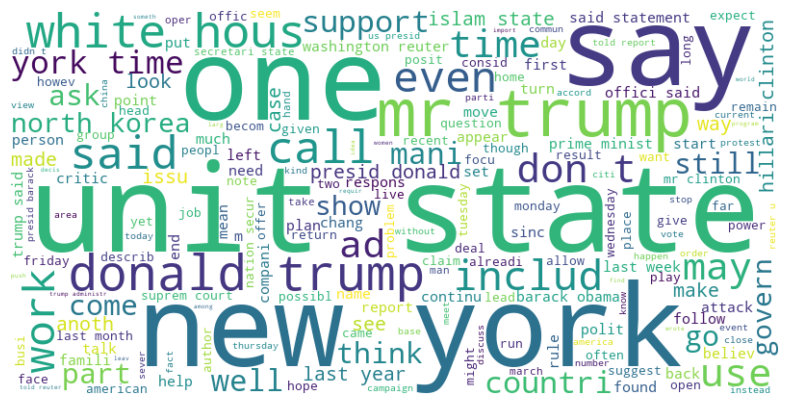

In [16]:
plt.figure(figsize=(10, 5))
plt.imshow(real_wordcloud, interpolation='bilinear')
plt.axis("off")  # Don't show the axes to keep it clean
plt.show()

### NLP Steps (TF-IDF Vectorization)

In [17]:
# Perform TF-IDF Vectorizer
vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(fakenews_df['title_text'])

#### Applying ML Models

In [18]:
# Random forest model

# split the data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(features, fakenews_df['label'], test_size=0.2, random_state=42)

# random forest regressor
randomforest_regressor = RandomForestClassifier(random_state=42)
randomforest_regressor.fit(X_train, y_train)

# predict on the test set and get classification report on precision, recall, F1-score
y_pred = randomforest_regressor.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94      7081
           1       0.93      0.94      0.94      7227

    accuracy                           0.94     14308
   macro avg       0.94      0.94      0.94     14308
weighted avg       0.94      0.94      0.94     14308



***Precision: A precision of 0.94 for class 0 means that 94% of the instances that the model predicted as class 0 were actually class 0.

Recall: A recall of 0.94 for class 0 means that the model correctly identified 94% of all actual instances of class 0.

F1-score:  An F1-score of 0.94 for class 0 indicates that the balance between precision and recall for class 0 predictions is quite good.

Support: The number of actual occurrences of the class in the specified dataset. For instance, there are 7081 instances of class 0 and 7227 instances of class 1.

Accuracy: The ratio of correct predictions to total predictions. An accuracy of 0.94 means the model made correct predictions 94% of the time.***

### XGBoost

XGBoost is a library which provides gradient boosted solutions for machine learning problems. It improves over RandomForest by providing regularization, parallel processing and efficient handling of sparse data (useful when we are dealing with featurized vectors). These optimizations result in a more generalized model over RandomForest

In [46]:
from xgboost import XGBClassifier

xgb_classifier = XGBClassifier(n_estimators=100, random_state=42)
xgb_classifier.fit(X_train, y_train)

y_pred = xgb_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      7081
           1       0.96      0.98      0.97      7227

    accuracy                           0.97     14308
   macro avg       0.97      0.97      0.97     14308
weighted avg       0.97      0.97      0.97     14308



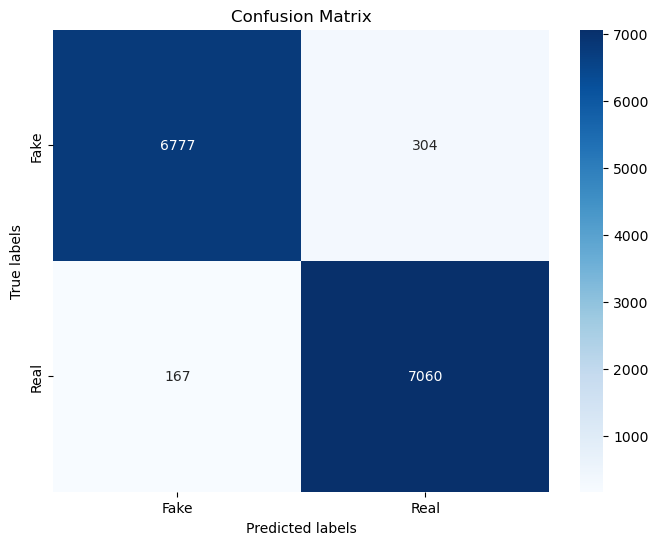

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
labels = ["Fake", "Real"]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [24]:
# Show an example of misclassified article

misclassified_idx = np.where(y_pred != y_test)[0]
i = np.random.choice(misclassified_idx)

# np.where was causing kernel to crash likely due to features being sparse array
matching_index = None
for idx, row in enumerate(features):
    if np.array_equal(X_test[i].toarray(), row.toarray()):
        matching_index = idx
        break

print(str.format("Predicted Label: \t'{}'", labels[y_pred[i]]))
print(str.format("True Label: \t\t'{}'", labels[y_test.iloc[i]]))

original_df = pd.read_csv("data/WELFake_Dataset.csv")

article = original_df.iloc[[matching_index]][['title', 'text']]
article


Predicted Label: 	'Fake'
True Label: 		'Real'


,title,text
5761,Voting to elect president of South Africa’s ANC closes: delegate,"JOHANNESBURG (Reuters) - Voting for the new leader of South Africa s ruling ANC ended on Monday about ten hours after delegates began casting ballots for either Deputy President Cyril Ramaphosa or Nkosazana Dlamini-Zuma, a senior party source told Reuters. Voting for top 6 is done, said the source, referring to the position of president of the African National Congress and the party s five other senior posts."


In [28]:
# plot the model training against different parameters
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

n_estimators = list(range(1,101))
max_depths = list(range(1,11))

# accuracy, precision, recall ,f1-score
estimator_scores = []

for n in n_estimators:
    xgb_classifier = XGBClassifier(n_estimators=n, random_state=42)
    xgb_classifier.fit(X_train, y_train)

    y_pred = xgb_classifier.predict(X_test)
    estimator_scores.append([
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred),
    ])

estimator_scores


[[0.9141738887335756,
  0.8734902253766654,
  0.9706655597066556,
  0.9195176300956875],
 [0.9248672071568353,
  0.9029342415509563,
  0.9537844195378442,
  0.927663010564565],
 [0.9267542633491753,
  0.9014944769330734,
  0.959872699598727,
  0.9297681275968369],
 [0.9320659770757618,
  0.9098414362468877,
  0.9607029196070292,
  0.9345806972674653],
 [0.9334637964774951,
  0.9083691266432383,
  0.9656842396568424,
  0.936150234741784],
 [0.9348616158792284,
  0.9078657509394843,
  0.9694202296942023,
  0.9376338329764454],
 [0.9380067095331284,
  0.9145958671200628,
  0.9676214196762142,
  0.9403617293081423],
 [0.9375873637126083,
  0.9140951882845189,
  0.9673446796734468,
  0.9399663865546218],
 [0.9405227844562483,
  0.9183727034120734,
  0.9683132696831327,
  0.9426820233043712],
 [0.9424098406485882,
  0.9218605876927132,
  0.9680365296803652,
  0.9443844492440605],
 [0.9442968968409281,
  0.9249273063706054,
  0.9683132696831327,
  0.9461231663624687],
 [0.9452054794520548,
  

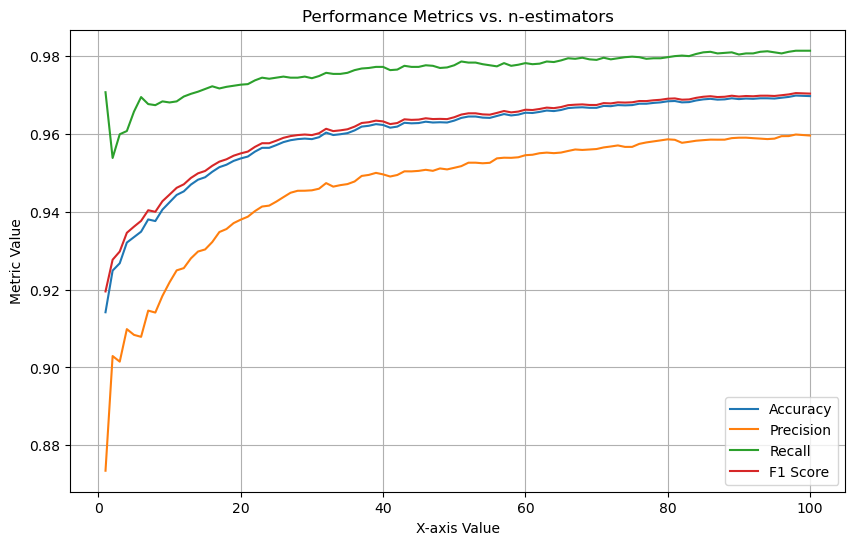

In [33]:
scores = np.array(estimator_scores)
accuracy = scores[:, 0]
precision = scores[:, 1]
recall = scores[:, 2]
f1 = scores[:, 3]

plt.figure(figsize=(10, 6))

plt.plot(n_estimators, accuracy, label='Accuracy')
plt.plot(n_estimators, precision, label='Precision')
plt.plot(n_estimators, recall, label='Recall')
plt.plot(n_estimators, f1, label='F1 Score')

plt.title('Performance Metrics vs. n-estimators')
plt.xlabel('X-axis Value')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)

plt.show()

In [34]:
max_depths = list(range(1,11))

# accuracy, precision, recall ,f1-score
d_scores = []

for d in max_depths:
    xgb_classifier = XGBClassifier(n_estimators=100, random_state=42, max_depth=d)
    xgb_classifier.fit(X_train, y_train)

    y_pred = xgb_classifier.predict(X_test)
    d_scores.append([
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred),
    ])

d_scores

[[0.9383561643835616,
  0.9190331528199709,
  0.9627784696277847,
  0.9403973509933775],
 [0.9545009784735812,
  0.944204269116455,
  0.9670679396706794,
  0.9554993506049627],
 [0.9615599664523343,
  0.9516980110945745,
  0.9732945897329459,
  0.9623751539198249],
 [0.9648448420464076,
  0.9562975027144408,
  0.9749550297495503,
  0.9655361425145598],
 [0.9670813530891809,
  0.9587180879956545,
  0.9768922097689221,
  0.9677198272907956],
 [0.9696673189823874,
  0.9595453930455959,
  0.9813200498132005,
  0.9703105760021891],
 [0.9708554654738608,
  0.9621335504885994,
  0.9809049398090494,
  0.9714285714285715],
 [0.9731618674867207,
  0.962552386102474,
  0.9851944098519441,
  0.973741794310722],
 [0.974559686888454,
  0.9654143496541435,
  0.9849176698491767,
  0.975068493150685],
 [0.9728823036063741,
  0.9639126305792972,
  0.9831188598311886,
  0.9734210165776133]]

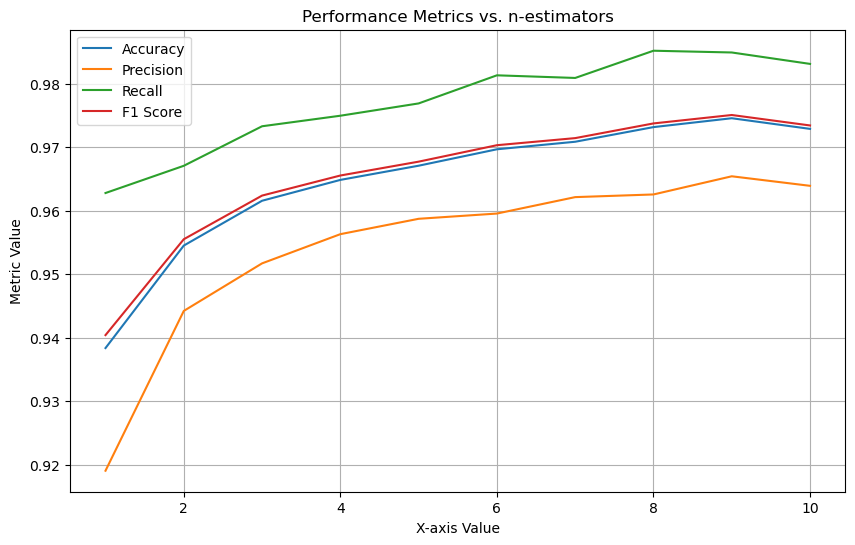

In [43]:
scores = np.array(d_scores)
accuracy = scores[:, 0]
precision = scores[:, 1]
recall = scores[:, 2]
f1 = scores[:, 3]

plt.figure(figsize=(10, 6))

plt.plot(max_depths, accuracy, label='Accuracy')
plt.plot(max_depths, precision, label='Precision')
plt.plot(max_depths, recall, label='Recall')
plt.plot(max_depths, f1, label='F1 Score')

plt.title('Performance Metrics vs. n-estimators')
plt.xlabel('X-axis Value')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)

plt.show()

### SVM - Support Vector Machine

A support vector machine (SVM) is a supervised machine learning algorithm that classifies data by finding an optimal line or hyperplane that maximizes the distance between each class in an N-dimensional space.

In [25]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Initialize and train the SVM classifier
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = svm_classifier.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      7081
           1       0.96      0.97      0.97      7227

    accuracy                           0.96     14308
   macro avg       0.96      0.96      0.96     14308
weighted avg       0.96      0.96      0.96     14308



### MLP - MultiLayer Perceptron

A multilayer perceptron (MLP) is a name for a modern feedforward artificial neural network, consisting of fully connected neurons with a nonlinear kind of activation function, organized in at least three layers, notable for being able to distinguish data that is not linearly separable.[1] It is a misnomer because the original perceptron used a Heaviside step function, instead of a nonlinear kind of activation function (used by modern networks).

In [26]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report


# Define the neural network architecture
model = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', 
                      alpha=0.0001, batch_size='auto', learning_rate='constant', 
                      learning_rate_init=0.001, max_iter=200, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

/Users/rahulbhargava/anaconda3/envs/kddm/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


              precision    recall  f1-score   support

           0       0.97      0.97      0.97      7081
           1       0.97      0.97      0.97      7227

    accuracy                           0.97     14308
   macro avg       0.97      0.97      0.97     14308
weighted avg       0.97      0.97      0.97     14308



### MultiNomial Naive Bayes

The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Initialize Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = nb_classifier.predict(X_test)

# Print classification report
print("Multinomial Naive Bayes Classifier:")
print(classification_report(y_test, y_pred))

### Ensemble Classifier
### MultiNomial NB + Gradient Boosting

"Add info"

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report

# Initialize individual classifiers
nb_classifier = MultinomialNB()
gbm_classifier = GradientBoostingClassifier()  # GBM classifier

# Create a list of tuples containing classifier name and classifier object
classifiers = [('Naive Bayes', nb_classifier), ('GBM', gbm_classifier)]

# Initialize VotingClassifier with soft voting and weights
voting_classifier = VotingClassifier(estimators=classifiers, voting='soft', weights=[1, 2])

# Fit the VotingClassifier
voting_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_ensemble = voting_classifier.predict(X_test)

# Print classification report
print("Ensemble Classifier (Naive Bayes + GBM):")
print(classification_report(y_test, y_pred_ensemble))